![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [983]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import os
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import collections
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [984]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [985]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [986]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [987]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [988]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [989]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [990]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [991]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [992]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [993]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [994]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [995]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
26278,id_7004,Paris,NaN,7005.0,NaN,11.0,"[['Great steak', 'Delicious Options'], ['11/12...",/Restaurant_Review-g187147-d11743155-Reviews-C...,d11743155,1,4.5
30396,id_383,Helsinki,NaN,384.0,NaN,32.0,"[['Great place', 'Cool bar with great rum base...",/Restaurant_Review-g189934-d6164392-Reviews-Na...,d6164392,1,4.0
34314,id_3108,London,"['Mediterranean', 'European', 'Turkish', 'Midd...",3114.0,$$ - $$$,124.0,"[['Pricey', 'Very good'], ['08/01/2017', '06/1...",/Restaurant_Review-g186338-d2510577-Reviews-Fo...,d2510577,1,4.0
3638,id_3638,Madrid,"['Mediterranean', 'Spanish']",2757.0,$$ - $$$,17.0,"[[], []]",/Restaurant_Review-g187514-d12506736-Reviews-G...,d12506736,0,0.0
26966,id_1832,Budapest,"['Japanese', 'Sushi']",1833.0,$$ - $$$,12.0,"[['Still under the minimum of the minimums', '...",/Restaurant_Review-g274887-d6278408-Reviews-Ke...,d6278408,1,3.5


In [996]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [997]:
# Всего имеем 4 столбца с пропусками для обработки: Cuisine Style, Price Range, Number of Reviews, Reviews
# Вынесем информацию о наличии пропусков в данных как отдельные признаки для каждой переменной (кроме Reviews-всего 2 пропущенных значения) с целью дальнейшего анализа зависимостей
data['Price Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [998]:
data['Price Range_isNAN'].value_counts()
data['Number_of_Reviews_isNAN'].value_counts()

0    46800
1     3200
Name: Number_of_Reviews_isNAN, dtype: int64

In [999]:
# Далее заполняем пропуски для каждой переменной:
# Пропуски значений для переменной Cuisine Style  и Price Range можно заполнить данными с сайта, однако в этом случае есть риск
# что это исказит модель, так как данные в исходном датасете неактуальные, а с сайта мы возьмем свежую информацию. За время сбора датасета рестораны
# могли скорректировать свою политику и изменить меню и цены.

In [1000]:
# 1. Reviews
data['Reviews'].value_counts()
data[pd.isna(data['Reviews'])]
# как мы видим, большинство значений Reviews - незаполненные отзывы - [[], []], для данной переменной есть только два пропуска,
# заполним пропуски частым значением -  [[], []] для дальнейшей обработки
data['Reviews'].fillna('[[], []]', inplace=True)

In [1001]:
# создадим на основе столбца Reviews переменную Reviews_dates, содержащую даты отзывов. Для дальнейшего анализа пропусков Number of Reviews и создания новых переменных
data['Reviews_dates']=data['Reviews'].apply(lambda x: re.findall("\d{2}/\d{2}/\d{4}",x))

In [1002]:
# 2. Cuisine Style
# в Reviews для части ресторанов с пропусками отражен тип кухни, можно провести opinion mining и извлечь необходимую информацию
# Пока заменим пропуски на Nan
data['Cuisine Style'].fillna('NaN', inplace=True)

In [1003]:
# 3. Price Range
# данные о ценах в ресторанах имеют градацию: $, $$ - $$$, $$$$, наиболее частое значение - средняя цена.
# заменим пропуски наиболее частым значением
data['Price Range'].value_counts()
data['Price Range'].fillna('$$ - $$$', inplace=True)

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

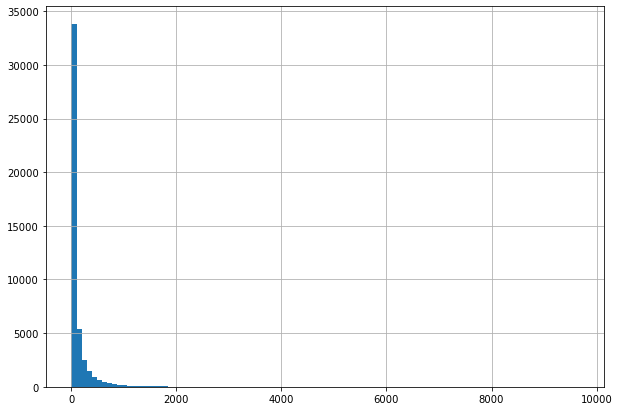

In [1004]:
# 4. Number of Reviews
# Числовой признак, посмотрим на распределение данных в нем:
plt.rcParams['figure.figsize'] = (10, 7)
data['Number of Reviews'].hist(bins=100)
data['Number of Reviews'].value_counts()

In [1005]:
# исходя из распеределения признака видим, что наиболее частое значение - 2, однако есть экстремально высокие значения, необходимо
# очистить данные от возможных выбросов (например, заменив их на верхнию(нижнюю) границы IQR).
# заполнение пропусков можно производить исходя из анализа созданной переменной - Reviews_dates
# в случае, если данная переменная не содержит значений, можем заполнить пропуск для Number of Reviews на 0,
# если содержит 1 отзыв, заполним пропуск - 1, иначе наиболее частым значением - 2, создадим для этого функцию.
def fillna_rwsnum(row):
    if pd.isna(row['Number of Reviews']):
        return len(row['Reviews_dates'])
    else:
        return row['Number of Reviews']


data['Number of Reviews'] = data.apply(lambda row: fillna_rwsnum(row), axis=1)

In [1006]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            50000 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price Range              50000 non-null  object 
 5   Number of Reviews        50000 non-null  float64
 6   Reviews                  50000 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Price Range_isNAN        50000 non-null  uint8  
 12  Number_of_Reviews_isNAN  50000 non-null  uint8  
 13  Reviews_dates            50000 non-null  object 
dtypes: float64(3), int64(1

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [1007]:
# 1. Restaurant_id
# по описанию данной переменной мы видим, что значения не уникальные и не являются id ресторана как таковым
# для ресторанов из одной группы, объединенных по Restaurant_id очень близкие значения столбца Ranking
# попробуем вывести среднее значение по рейтингу для этих групп:
data.groupby(['Restaurant_id'])['Ranking'].mean().sort_values()
# по результату видим, что Restaurant_id отражает рейтинг ресторанов по Rankig (есть смещение на 1).Между данными переменными есть сильная корреляция,
# проверем это, переведя в числовые переменные:
data['Restaurant_id'] = data['Restaurant_id'].apply(
    lambda x: int(re.sub('id_', '', x)))
data['Restaurant_id'].corr(data['Ranking'])
# данную переменную необходимо удалить:
data = data.drop(['Restaurant_id'], axis=1)

In [1008]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     50000 non-null  object 
 1   Cuisine Style            50000 non-null  object 
 2   Ranking                  50000 non-null  float64
 3   Price Range              50000 non-null  object 
 4   Number of Reviews        50000 non-null  float64
 5   Reviews                  50000 non-null  object 
 6   URL_TA                   50000 non-null  object 
 7   ID_TA                    50000 non-null  object 
 8   sample                   50000 non-null  int64  
 9   Rating                   50000 non-null  float64
 10  Price Range_isNAN        50000 non-null  uint8  
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
 12  Reviews_dates            50000 non-null  object 
dtypes: float64(3), int64(1), object(7), uint8(2)
memory usage: 4.3+ MB


In [1009]:
# 2. City
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# задублируем City для удобства последующего анализа
data['City_'] = data['City']
data = pd.get_dummies(data, columns=['City', ], dummy_na=True)

In [1010]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cuisine Style            50000 non-null  object 
 1   Ranking                  50000 non-null  float64
 2   Price Range              50000 non-null  object 
 3   Number of Reviews        50000 non-null  float64
 4   Reviews                  50000 non-null  object 
 5   URL_TA                   50000 non-null  object 
 6   ID_TA                    50000 non-null  object 
 7   sample                   50000 non-null  int64  
 8   Rating                   50000 non-null  float64
 9   Price Range_isNAN        50000 non-null  uint8  
 10  Number_of_Reviews_isNAN  50000 non-null  uint8  
 11  Reviews_dates            50000 non-null  object 
 12  City_                    50000 non-null  object 
 13  City_Amsterdam           50000 non-null  uint8  
 14  City_Athens           

In [1011]:
# 3. Cuisine Style
# для удобства обработки переведем значения столбца в списки:
data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: None if pd.isnull(x) else re.sub('\s\'|\'|\[|\]', '', x).split(','))

In [1012]:
# составим словарь уникальных значений с количеством
cus = collections.Counter()
for i in data['Cuisine Style']:
    if i is not None and len(i) != 0:
        for j in i:
            cus[j] += 1
len(cus)
cus.most_common()
# как видим, наиболее частое значение - Vegetarian Friendly, также можно выделить группы кухонь из имеющихся значений

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('NaN', 11590),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727),
 ('American', 1642),
 ('Sushi', 1450),
 ('Chinese', 1446),
 ('Portuguese', 1385),
 ('Indian', 1328),
 ('Middle Eastern', 980),
 ('Thai', 923),
 ('Wine Bar', 877),
 ('German', 820),
 ('Halal', 773),
 ('Greek', 768),
 ('Healthy', 758),
 ('Fusion', 748),
 ('Czech', 745),
 ('Steakhouse', 729),
 ('Barbecue', 710),
 ('Contemporary', 652),
 ('Soups', 630),
 ('Eastern European', 629),
 ('Vietnamese', 622),
 ('Grill', 617),
 ('Gastropub', 608),
 ('Turkish', 574),
 ('Mexican', 572),
 ('South American', 490),
 ('Delicatessen', 473),
 ('Austrian', 462),
 ('Polish', 45

In [1013]:
# сформируем dummy-переменные на основе значений и сформированного ранее списка Cuisine Style
for i in cus.keys():
    data['Cuisine_' +
         i] = data['Cuisine Style'].apply(lambda x: 1 if i in x else 0)

In [1014]:
# 4. Price Range
data['Price Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [1015]:
# заменим значения в переменной Price Range на числовые: 1, 2, 3 в соответствии с уровнем цен:
data['Price Range'] = data['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3)

In [1016]:
data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

In [1017]:
# 5. ID_TA
# предсаляет собой id ресторана, возможно будет полезен, так как косвено отражает то, насколько давно ресторан находится на сайте (в базе) tripadviser
# т.е. чем ниже значение, тем дольше ресторан на сайте, может быть полезным, переведем в числовой:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

In [1018]:
data['ID_TA'].value_counts()
# обнаружили, что есть задублированные строки, посмотрим на них детальнее:
ta = pd.DataFrame(data['ID_TA'].value_counts())
ta = ta[ta['ID_TA'] > 1]
# все значения одинаковые, кроме значения Ranking. Необходимо сгруппировать по ID_TA и вычислить среднее по Ranking, обновить даные средними значениями
newrank = pd.DataFrame(data[data['ID_TA'].isin(ta.index)].groupby(
    ['ID_TA'])['Ranking'].mean()).reset_index()
# def fillrank_mean(row):
#    if len(newrank[newrank['ID_TA']==row['ID_TA']])!=0:
#        return newrank[newrank['ID_TA']==row['ID_TA']]['Ranking']
#    else:
#        return row['Ranking']
# for i in newrank['ID_TA']:
#    data['Ranking_new']=data.apply(lambda row: fillrank_mean(row), axis=1)

In [1019]:
#прочие категориальные переменные - Reviews, URL_TA, Reviews_dates нужны для подготовки новых признаков. Удалим их позже 

In [1020]:
# 6. Number of Reviews
# Как уже отмечалось выше колличественный признак Number of Reviews содержит экстримально высокие
# значения, попробуем очистить данные от возможных выбросов, поределим границы IQR).
data['Number of Reviews'].value_counts()
# зададим функцию поиска персентилей 25 и 75 и IQR


def iqrdef(s):
    # определение границ выбровсов для числовых переменных:
    print('Значения находятся в диапазоне от', s.min(), 'до', s.max())
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    IQR = perc75 - perc25
    l = perc75 + 1.5*IQR
    f = perc25 - 1.5*IQR
    print('Большая часть значений лежит между', perc25, 'и', perc75,
          '(25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {})'.format(perc75))
    print('IQR: {}, '.format(IQR), 'Границы выбросов: [{}, {}].'.format(f, l))
    return l


m = iqrdef(data['Number of Reviews'])
# верхняя граница - 252, однако выше нее лежит слишком много значений, нам она не подходит
# вероятно такое распределение признака обусловлено разным размером городов (числом населения). Посмотрим более детально в след. разделе

Значения находятся в диапазоне от 0.0 до 9660.0
Большая часть значений лежит между 7.0 и 105.0 (25-й перцентиль: 7.0, 75-й перцентиль: 105.0)
IQR: 98.0,  Границы выбросов: [-140.0, 252.0].


In [1021]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 171 entries, Cuisine Style to Cuisine_Latvian
dtypes: float64(3), int64(129), object(5), uint8(34)
memory usage: 53.9+ MB


# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

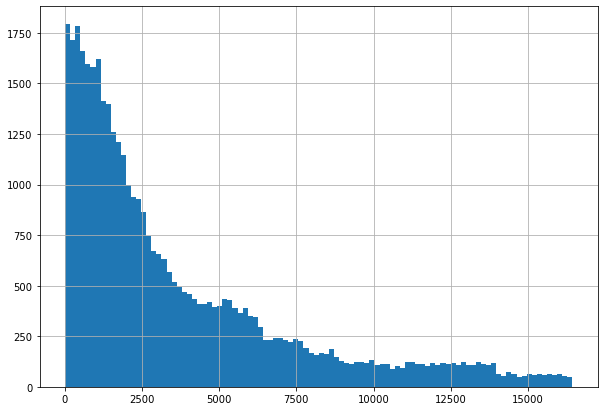

In [1022]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

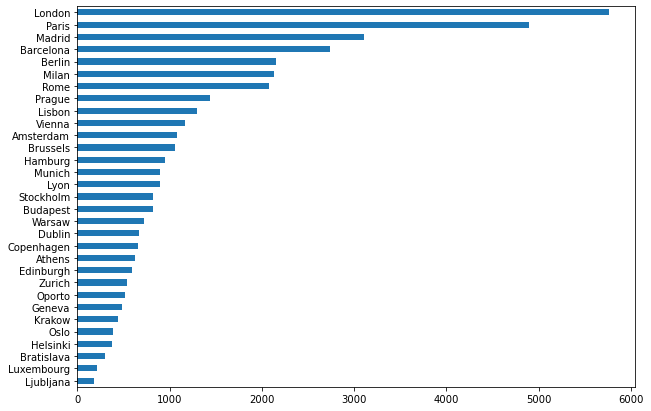

In [1023]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

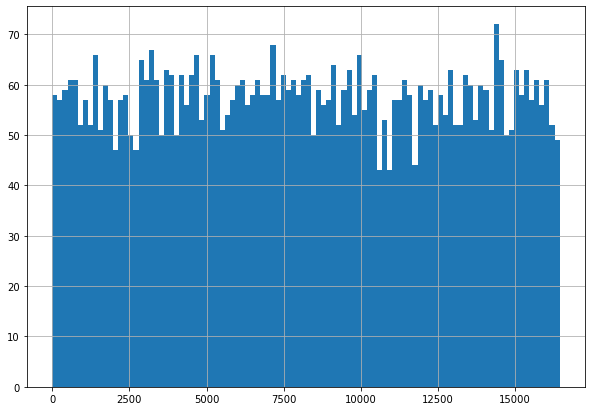

In [1024]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

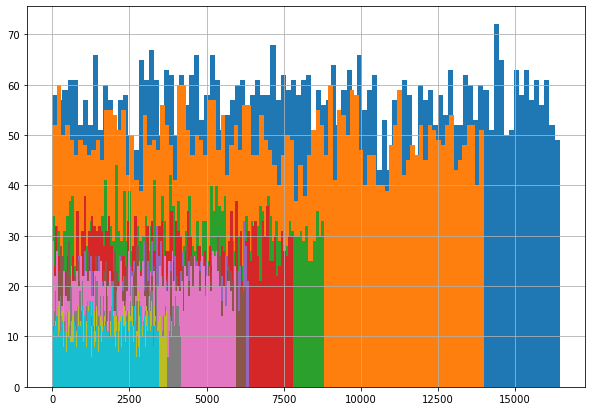

In [1025]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [952]:
# Введем дополнительные переменные:

In [1026]:
# 1. Ranking в отношении к общему числу ресторанов в городе - для решения проблемы с Ranking, описанной выше
# словарь с данными об общем количестве ресторанов с tripadviser
total_count = {'London': 19978, 'Paris': 17121, 'Madrid': 11298, 'Barcelona': 9497, 'Berlin': 6494, 'Milan': 7422, 'Rome': 10916, 'Prague': 5391, 'Lisbon': 4885, 'Vienna': 4120, 'Amsterdam': 3979, 'Brussels': 3610, 'Hamburg': 3290, 'Munich': 3150, 'Lyon': 2783,
               'Stockholm': 2998, 'Budapest': 3055, 'Warsaw': 3227, 'Dublin': 2341, 'Copenhagen': 2329, 'Athens': 2543, 'Edinburgh': 1889, 'Zurich': 1859, 'Oporto': 1986, 'Geneva': 1684, 'Krakow': 1749, 'Oslo': 1273, 'Helsinki': 1491, 'Bratislava': 1262, 'Luxembourg': 736, 'Ljubljana': 599}
# создаем относительную переменную


def fillnew_rank(row):
    if row['City_'] in total_count.keys():
        return row['Ranking']/total_count.get(row['City_'])
    else:
        return None


data['Ranking_per_total_restcnt'] = data.apply(
    lambda row: fillnew_rank(row), axis=1)

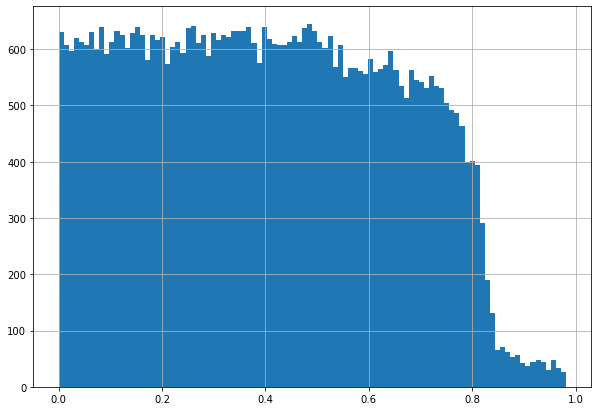

In [1027]:
# посмотрим на распределение нового признака:
plt.rcParams['figure.figsize'] = (10, 7)
data['Ranking_per_total_restcnt'].hist(bins=100)
# мы видим,что новые данные распредены более нормально нежели старый признак.

In [1028]:
# 2. Численность наседения в городах City_population
# создадим словарь с данными о численности населения
pop = {'London': 8908081, 'Paris': 2148327, 'Madrid': 3266126, 'Barcelona': 1664182, 'Berlin': 3644826, 'Milan': 1378689, 'Rome': 2870500, 'Prague': 1301132, 'Lisbon': 505526, 'Vienna': 1897491, 'Amsterdam': 872757, 'Brussels': 179277, 'Hamburg': 1841179, 'Munich': 1471508, 'Lyon': 506615, 'Stockholm': 961609,
       'Budapest': 1752286, 'Warsaw': 1790658, 'Dublin': 1173179, 'Copenhagen': 615993, 'Athens': 664046, 'Edinburgh': 488100, 'Zurich': 428737, 'Oporto': 237591, 'Geneva': 200548, 'Krakow': 779115, 'Oslo': 673469, 'Helsinki': 655281, 'Bratislava': 437725, 'Luxembourg': 115227, 'Ljubljana': 284355}
# добавим столбец по численности населения в городах
data['City_population'] = data['City_'].apply(lambda x: pop.get(x))

In [1029]:
# 3.Количество (разнообразие) кухонь в ресторане Cuisine_cnt на основе данных 'Cuisine Style'
data['Cuisine_cnt'] = data['Cuisine Style'].apply(
    lambda x: None if x is None else int(len(x)))

In [1030]:
# 4. Количество ревью по ресторану на общую численность населения в городе
# проанализируем распределение 'Number of Reviews' относительно городов:
data['Revies_per_population'] = data['Number of Reviews']/data['City_population']

In [1031]:
# 5. Количество дней со дня последнего ревью Days_from_las_revie
def maxdate(lst):
    l = []
    now = datetime.now()
    if len(lst) != 0:
        for i in lst:
            l.append(datetime.strptime(i, '%m/%d/%Y'))
        return (now-max(l)).days
    else:
        return -1


data['Days_from_las_revie'] = data['Reviews_dates'].apply(lambda x: maxdate(x))

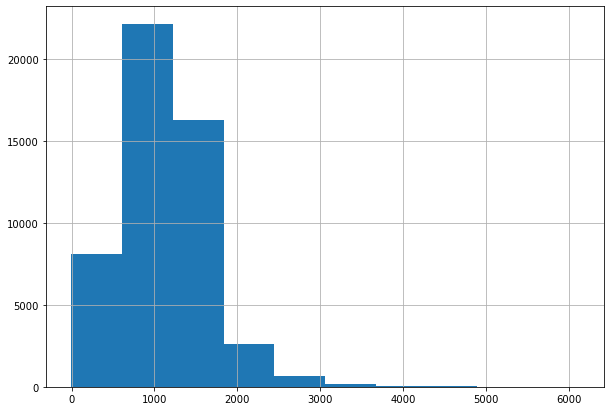

In [1032]:
data['Days_from_las_revie'].hist()

In [1033]:
# 6. Количество дней между двумя последними ревью
def difdate(lst):
    if len(lst) == 2:
        d = (datetime.strptime(lst[0], '%m/%d/%Y') -
             datetime.strptime(lst[1], '%m/%d/%Y')).days
        return d
    else:
        return -1


data['Dif_date_revie'] = data['Reviews_dates'].apply(lambda x: difdate(x))

In [1034]:
data['Dif_date_revie'].value_counts()

-1       13809
 1         814
 0         631
 2         618
 3         594
         ...  
 948         1
 884         1
 692         1
 2374        1
 1727        1
Name: Dif_date_revie, Length: 1650, dtype: int64

### Посмотрим распределение целевой переменной

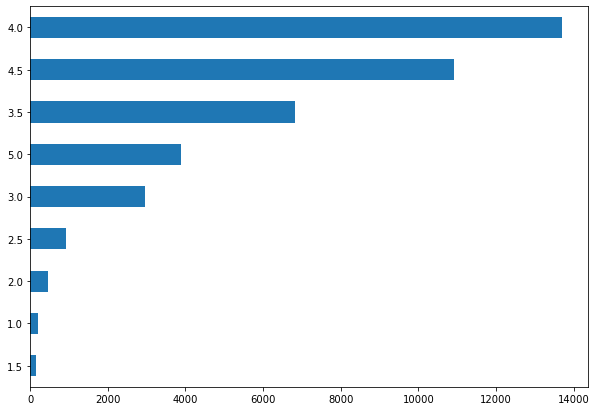

In [1035]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

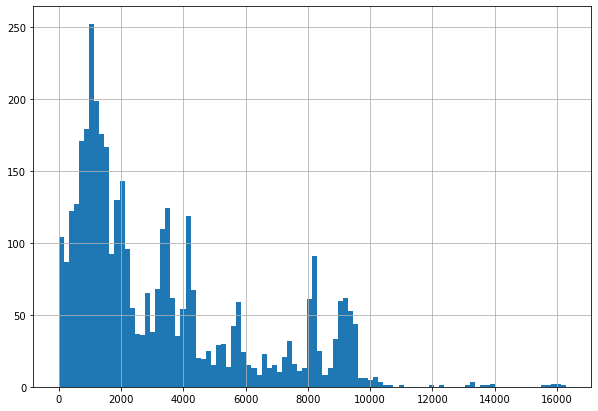

In [1036]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

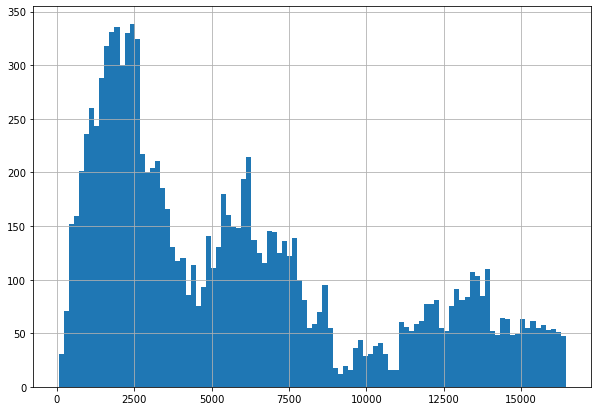

In [1037]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

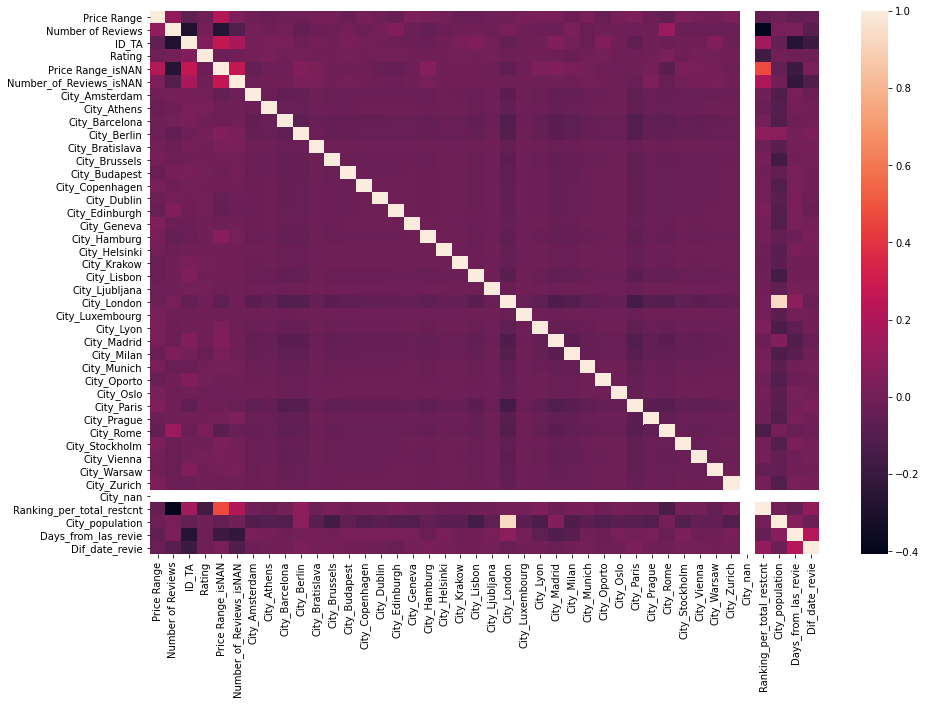

In [796]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [1038]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [1039]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id', 'URL_TA'], axis=1, inplace=True)

    # ################### 2. NAN ##############################################################
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...

    # 0. формируем переменные для хранения ин-ции о пропусках
    df_output['Price Range_isNAN'] = pd.isna(
        df_output['Price Range']).astype('uint8')
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number of Reviews']).astype('uint8')

    # 1. Reviews
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    df_output['Reviews_dates'] = df_output['Reviews'].apply(
        lambda x: re.findall("\d{2}/\d{2}/\d{4}", x))

    # 2. Cuisine Style
    df_output['Cuisine Style'].fillna('NaN', inplace=True)

    # 3. Price Range
    df_output['Price Range'].fillna('$$ - $$$', inplace=True)

    # 4. Number of Reviews
    def fillna_rwsnum(row):
        if pd.isna(row['Number of Reviews']):
            return len(row['Reviews_dates'])
        else:
            return row['Number of Reviews']
    df_output['Number of Reviews'] = df_output.apply(
        lambda row: fillna_rwsnum(row), axis=1)

    # ################### 3. Encoding ##############################################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # 2. City
    df_output['City_'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=['City', ], dummy_na=True)
    # 3. Cuisine Style
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(
        lambda x: None if pd.isnull(x) else re.sub('\s\'|\'|\[|\]', '', x).split(','))
    cus = collections.Counter()
    for i in df_output['Cuisine Style']:
        if i is not None and len(i) != 0:
            for j in i:
                cus[j] += 1
    # сформируем dummy-переменные на основе значений и сформированного ранее списка Cuisine Style
    for i in cus.keys():
        df_output['Cuisine_' +
                  i] = df_output['Cuisine Style'].apply(lambda x: 1 if i in x else 0)

    # 4. Price Range
    # заменим значения в переменной Price Range на числовые: 1, 2, 3 в соответствии с уровнем цен:
    df_output['Price Range'] = df_output['Price Range'].apply(
        lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3)

    # 5. ID_TA
    # трансформируем в числовую переменную - ухудшает модель,пока убрали
    df_output['ID_TA'] = df_output['ID_TA'].apply(lambda x: int(x[1:]))

    # ################### 4. Feature Engineering ####################################################
    # 1. Ranking в отношении к общему числу ресторанов в городе - для решения проблемы с Ranking
    # словарь с данными об общем количестве ресторанов с tripadviser
    total_count = {'London': 19978, 'Paris': 17121, 'Madrid': 11298, 'Barcelona': 9497, 'Berlin': 6494, 'Milan': 7422, 'Rome': 10916, 'Prague': 5391, 'Lisbon': 4885, 'Vienna': 4120, 'Amsterdam': 3979, 'Brussels': 3610, 'Hamburg': 3290, 'Munich': 3150, 'Lyon': 2783,
                   'Stockholm': 2998, 'Budapest': 3055, 'Warsaw': 3227, 'Dublin': 2341, 'Copenhagen': 2329, 'Athens': 2543, 'Edinburgh': 1889, 'Zurich': 1859, 'Oporto': 1986, 'Geneva': 1684, 'Krakow': 1749, 'Oslo': 1273, 'Helsinki': 1491, 'Bratislava': 1262, 'Luxembourg': 736, 'Ljubljana': 599}
    # создаем относительную переменную

    def fillnew_rank(row):
        if row['City_'] in total_count.keys():
            return row['Ranking']/total_count.get(row['City_'])
        else:
            return None
    df_output['Ranking_per_total_restcnt'] = df_output.apply(
        lambda row: fillnew_rank(row), axis=1)

    # 2. Численность наседения в городах City_population
    # создадим словарь с данными о численности населения
    pop = {'London': 8908081, 'Paris': 2148327, 'Madrid': 3266126, 'Barcelona': 1664182, 'Berlin': 3644826, 'Milan': 1378689, 'Rome': 2870500, 'Prague': 1301132, 'Lisbon': 505526, 'Vienna': 1897491, 'Amsterdam': 872757, 'Brussels': 179277, 'Hamburg': 1841179, 'Munich': 1471508, 'Lyon': 506615, 'Stockholm': 961609,
           'Budapest': 1752286, 'Warsaw': 1790658, 'Dublin': 1173179, 'Copenhagen': 615993, 'Athens': 664046, 'Edinburgh': 488100, 'Zurich': 428737, 'Oporto': 237591, 'Geneva': 200548, 'Krakow': 779115, 'Oslo': 673469, 'Helsinki': 655281, 'Bratislava': 437725, 'Luxembourg': 115227, 'Ljubljana': 284355}
    # добавим столбец по численности населения в городах
    df_output['City_population'] = df_output['City_'].apply(
        lambda x: pop.get(x))

    # 3.Количество (разнообразие) кухонь в ресторане Cuisine_cnt на основе данных 'Cuisine Style' - ухудшает модел
    df_output['Cuisine_cnt'] = df_output['Cuisine Style'].apply(
        lambda x: None if x is None else int(len(x)))

    # 4. Количество ревью по ресторану на общую численность населения в городе - ухудшает модель
    df_output['Revies_per_population'] = df_output['Number of Reviews'] / \
        df_output['City_population']

    # 5. Количество дней со дня последнего ревью Days_from_las_revie
    def maxdate(lst):
        l = []
        now = datetime.now()
        if len(lst) != 0:
            for i in lst:
                l.append(datetime.strptime(i, '%m/%d/%Y'))
                return (now-max(l)).days
        else:
            return -1
    df_output['Days_from_las_revie'] = df_output['Reviews_dates'].apply(
        lambda x: maxdate(x))

    # 6. Количество дней между двумя последними ревью
    def difdate(lst):
        if len(lst) == 2:
            d = (datetime.strptime(lst[0], '%m/%d/%Y') -
                 datetime.strptime(lst[1], '%m/%d/%Y')).days
            return d
        else:
            return -1
    df_output['Dif_date_revie'] = df_output['Reviews_dates'].apply(
        lambda x: difdate(x))

    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

In [1040]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


#### Запускаем и проверяем что получилось

In [1041]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Price Range_isNAN,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,...,Cuisine_Xinjiang,Cuisine_Burmese,Cuisine_Fujian,Cuisine_Latvian,Ranking_per_total_restcnt,City_population,Cuisine_cnt,Revies_per_population,Days_from_las_revie,Dif_date_revie
5389,2613.0,2,21.0,8277103,0,0.0,1,0,0,0,...,0,0,0,0,0.352061,1378689,1,0.000015,-1,-1
41326,1286.0,2,12.0,5822505,1,4.5,1,0,0,0,...,0,0,0,0,0.408254,1471508,1,0.000008,1184,94
48842,3187.0,2,4.0,13190687,1,5.0,0,0,0,0,...,0,0,0,0,0.335580,1664182,4,0.000002,1128,13
49551,10451.0,2,14.0,12954608,1,3.5,0,0,0,0,...,0,0,0,0,0.523125,8908081,2,0.000002,1111,24
40693,266.0,1,449.0,4565320,1,4.5,0,0,0,0,...,0,0,0,0,0.013315,8908081,4,0.000050,1107,2
41604,867.0,2,319.0,3948247,1,4.5,0,0,0,0,...,0,0,0,0,0.050640,2148327,5,0.000148,1150,26
27942,152.0,2,17.0,8274292,1,4.5,0,0,0,0,...,0,0,0,0,0.120444,437725,4,0.000039,1369,-1
22637,2275.0,2,7.0,10622174,1,5.0,0,0,0,0,...,0,0,0,0,0.350323,3644826,5,0.000002,1205,-1
41179,323.0,2,102.0,2723610,1,4.5,0,0,0,0,...,0,0,0,0,0.116062,506615,4,0.000201,1748,323
19012,13097.0,2,82.0,10115118,1,3.0,0,0,0,0,...,0,0,0,0,0.764967,2148327,3,0.000038,1178,57


In [1042]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 172 entries, Ranking to Dif_date_revie
dtypes: float64(5), int64(133), uint8(34)
memory usage: 54.3 MB


In [1043]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [1044]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1045]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (32000, 170), (8000, 170))

# Model 
Сам ML

In [1046]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [1047]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1048]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1049]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19916999999999999


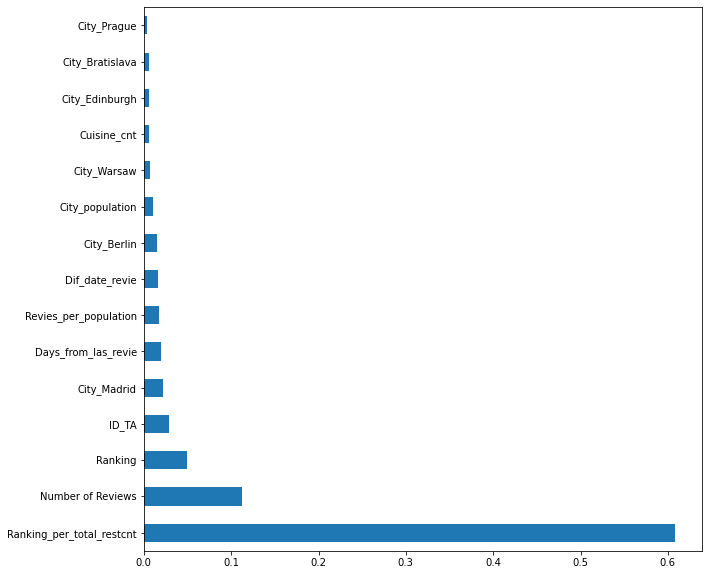

In [1050]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [1051]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,ID_TA,Rating,Price Range_isNAN,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,...,Cuisine_Xinjiang,Cuisine_Burmese,Cuisine_Fujian,Cuisine_Latvian,Ranking_per_total_restcnt,City_population,Cuisine_cnt,Revies_per_population,Days_from_las_revie,Dif_date_revie
87,7928.0,2,3.0,12921076,0.0,0,0,0,0,0,...,0,0,0,0,0.463057,2148327,2,0.000001,1165,-1
3691,1801.0,1,8.0,806662,0.0,0,0,0,0,0,...,0,0,0,0,0.334075,1301132,1,0.000006,1256,20
6842,1964.0,1,0.0,11956653,0.0,0,1,0,0,0,...,0,0,0,0,0.608615,1790658,1,0.000000,-1,-1
433,471.0,2,65.0,8736974,0.0,0,0,0,0,0,...,0,0,0,0,0.072528,3644826,3,0.000018,1113,1
5504,1381.0,2,5.0,11955151,0.0,1,0,0,0,0,...,0,0,0,0,0.256168,1301132,1,0.000004,1171,69
5303,537.0,3,35.0,4296323,0.0,0,0,0,0,0,...,0,0,0,0,0.318884,200548,7,0.000175,1324,111
7603,1392.0,2,318.0,1125552,0.0,0,0,0,0,0,...,0,0,0,0,0.127519,2870500,4,0.000111,1266,64
7089,1172.0,2,2.0,11960922,0.0,1,0,0,0,0,...,0,0,0,0,0.670097,779115,1,0.000003,-1,-1
1227,1718.0,2,8.0,4149186,0.0,1,0,0,0,0,...,0,0,0,0,0.416990,1897491,1,0.000004,1666,619
2313,7247.0,2,19.0,1156130,0.0,0,0,0,0,1,...,0,0,0,0,0.763083,1664182,1,0.000011,1270,348


In [1052]:
test_data = test_data.drop(['Rating'], axis=1)

In [1053]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [1054]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1055]:
predict_submission

array([3.025, 4.21 , 4.21 , ..., 2.99 , 4.49 , 4.395])

In [1056]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.025
1,id_1,4.210
2,id_2,4.210
3,id_3,4.375
4,id_4,4.500
5,id_5,4.515
6,id_6,1.850
7,id_7,2.875
8,id_8,4.375
9,id_9,4.625


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
